A toy model to compare two (univariate) time series: one with an underlying modulation and one without (purely random). Gausian noise is added to the time series, which can have a larger variance of the modulation amplitude (as is set now; play with the values).
The goal is to see when the modulation can be detected.

In [1]:
import numpy as np
import scipy.stats as stt
import matplotlib.pyplot as pp

T = 20 # number of observed time samples
vT = np.arange(T) # vector of time stamps
n_sub = 10 # number of subjects (repetitions of the same experience)

# normal distribution (white noise with unit variance, no temporal correlations)
ts_rand = np.random.randn(T,n_sub)

# generation of time series with underlying modulation
a = 0.2 # amplitude of modulation
f = 0.2 # frequency of modulation
v_mod = a * np.sin(vT*f*2*np.pi)
ts_mod = np.outer(v_mod,np.ones([n_sub])) + np.random.randn(T,n_sub)

pp.figure()
pp.subplot(211)
pp.plot(vT,ts_mod,color='r')
pp.plot(vT,v_mod,color=[0.5,0,0],ls='--')
pp.subplot(212)
pp.plot(vT,ts_rand,color='k')
pp.xlabel('time')
pp.savefig('indiv_ts')

pp.show()


<Figure size 640x480 with 2 Axes>

The average signal over subjects can provide insght about the modulation. The standard error of the mean gives the variability over the subjects, when estimating the average signal (hence the hypothesis about a common modulation).

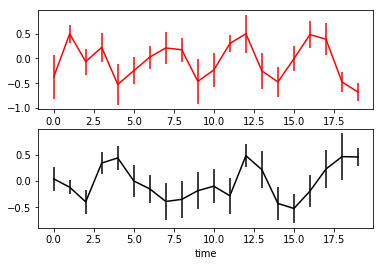

In [2]:
pp.figure()
pp.subplot(211)
pp.errorbar(vT,ts_mod.mean(1),yerr=ts_mod.std(1)/np.sqrt(n_sub),color='r')
pp.subplot(212)
pp.errorbar(vT,ts_rand.mean(1),yerr=ts_rand.std(1)/np.sqrt(n_sub),color='k')
pp.xlabel('time')
pp.savefig('sem')

pp.show()


To detect the modulation, we calculate the spectrum of the observed time series.

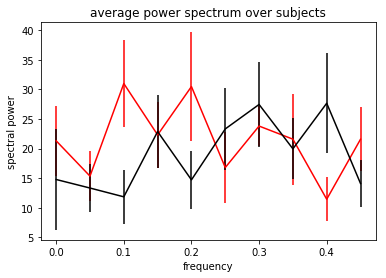

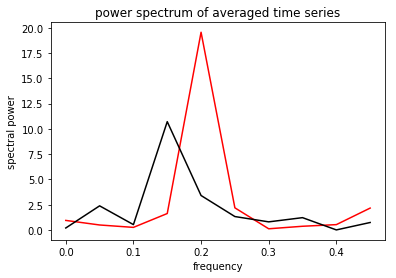

In [3]:
# average power spectrum over subjects

freq = np.fft.fftfreq(T,1)[:int(T/2)]
pws_rand = np.abs(np.fft.fft(ts_rand,axis=0)[:int(T/2),:])**2
pws_mod = np.abs(np.fft.fft(ts_mod,axis=0)[:int(T/2),:])**2

pp.figure()
pp.errorbar(freq,pws_mod.mean(1),yerr=pws_mod.std(1)/np.sqrt(n_sub),color='r')
pp.errorbar(freq,pws_rand.mean(1),yerr=pws_rand.std(1)/np.sqrt(n_sub),color='k')
pp.xlabel('frequency')
pp.ylabel('spectral power')
pp.title('average power spectrum over subjects')
pp.savefig('av_spectrum')

# power spectrum of averaged time series (over subjects)

pws_av_rand = np.abs(np.fft.fft(ts_rand.mean(1),axis=0)[:int(T/2)])**2
pws_av_mod = np.abs(np.fft.fft(ts_mod.mean(1),axis=0)[:int(T/2)])**2

pp.figure()
pp.plot(freq,pws_av_mod,color='r')
pp.plot(freq,pws_av_rand,color='k')
pp.xlabel('frequency')
pp.ylabel('spectral power')
pp.title('power spectrum of averaged time series')
pp.savefig('spectrum_av')

pp.show()

The power spectrum of the averaged time series has a clear peak, but its significance should be verified. To do so, we generate surrogates with shuffling the time series (independently for each subject).

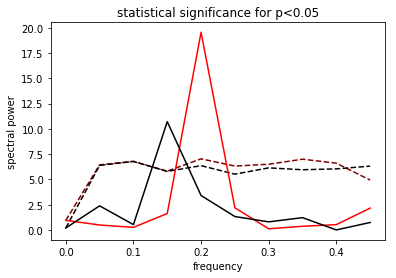

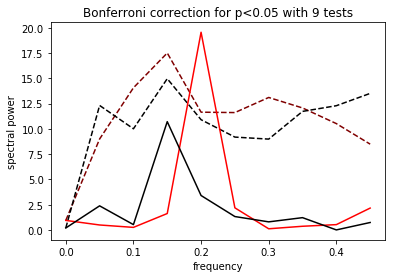

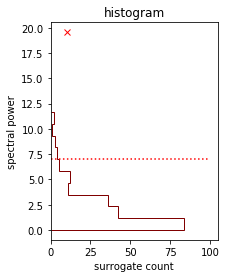

In [13]:
# surrogate time series

n_shuf = 200
ts_rand_shuf = np.zeros([T,n_sub,n_shuf])
ts_mod_shuf = np.zeros([T,n_sub,n_shuf])
for i_shuf in range(n_shuf):
    if True: # random permutations
        rand_ind = np.argsort(np.random.rand(T,n_sub),axis=0) # random indices (over the second dimension)
        for i_sub in range(n_sub):
            ts_rand_shuf[:,i_sub,i_shuf] = ts_rand[rand_ind[:,i_sub],i_sub]
            ts_mod_shuf[:,i_sub,i_shuf] = ts_mod[rand_ind[:,i_sub],i_sub]
    else: # circular shift
        rand_ind = np.random.randint(T,size=[n_sub]) # random indices (one per subject)
        for i_sub in range(n_sub):
            ts_rand_shuf[:,i_sub,i_shuf] = np.roll(ts_rand[:,i_sub],rand_ind[i_sub])
            ts_mod_shuf[:,i_sub,i_shuf] = np.roll(ts_mod[:,i_sub],rand_ind[i_sub])

# significance test for power spectrum

pws_av_rand_shuf = np.abs(np.fft.fft(ts_rand_shuf.mean(1),axis=0)[:int(T/2)])**2
pws_av_rand_shuf = np.sort(pws_av_rand_shuf,axis=1) # sort the distribution of surrogate values (for each frequency)

pws_av_mod_shuf = np.abs(np.fft.fft(ts_mod_shuf.mean(1),axis=0)[:int(T/2)])**2
pws_av_mod_shuf = np.sort(pws_av_mod_shuf,axis=1) # sort the distribution of surrogate values (for each frequency)

pval = 0.05 # desired p-value threshold
n_comp = 9

pp.figure()
pp.plot(freq,pws_av_mod_shuf[:,-int(pval*n_shuf)],color=[0.5,0,0],ls='--')
pp.plot(freq,pws_av_rand_shuf[:,-int(pval*n_shuf)],color='k',ls='--')
pp.plot(freq,pws_av_mod,color='r')
pp.plot(freq,pws_av_rand,color='k')
pp.xlabel('frequency')
pp.ylabel('spectral power')
pp.title('statistical significance for p<0.05')
pp.savefig('sig_spectrum')

pp.figure()
pp.plot(freq,pws_av_mod_shuf[:,-int(pval*n_shuf/n_comp)],color=[0.5,0,0],ls='--')
pp.plot(freq,pws_av_rand_shuf[:,-int(pval*n_shuf/n_comp)],color='k',ls='--')
pp.plot(freq,pws_av_mod,color='r')
pp.plot(freq,pws_av_rand,color='k')
pp.xlabel('frequency')
pp.ylabel('spectral power')
pp.title('Bonferroni correction for p<0.05 with 9 tests')
pp.savefig('sig_Bonf_spectrum')

i_f = 4 # index of frequency for histogram
pp.figure(figsize=[3,4])
pp.hist(pws_av_mod_shuf[i_f,:],orientation='horizontal',histtype='step',color=[0.5,0,0])
#pp.plot([0,100],[pws_av_mod_shuf[i_f,-int(pval*n_shuf/n_comp)]]*2,'--r')
pp.plot([0,100],[pws_av_mod_shuf[i_f,-int(pval*n_shuf)]]*2,':r')
pp.plot(10,pws_av_mod[i_f],'xr')
pp.xlabel('surrogate count')
pp.ylabel('spectral power')
pp.title('histogram')
pp.savefig('hist_surr')

pp.show()